In [1]:
%load_ext ipytelegram
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
from tqdm.notebook import tqdm

tqdm.pandas()
import warnings

from IPython.core import display as ICD

warnings.filterwarnings("ignore")
#%telegram_setup 5338324836:AAFIYlGtz6tCdfpWZaq7H8PMwQ1kmkykWHY 739485635

# *Data Research*

In [18]:
data = pd.read_csv("../Downloads/SA_train.csv")
column_names = [
    "pharmacy",
    "card_num",
    "receipt_date",
    "product",
    "product_code",
    "cashier_num",
    "receipt_num",
    "application",
    "retail_price",
]
data = data.rename(columns=dict(zip(list(data.columns), column_names)))
print(f"Размер исходных данных: {data.shape}")
data.head()

Размер исходных данных: (3937378, 9)


,pharmacy,card_num,receipt_date,product,product_code,cashier_num,receipt_num,application,retail_price
0,0,2340614,2018-01-22,769838,11091,0,0,379749,1749.70
1,0,2340614,2018-01-22,777940,11709,0,0,379964,3873.98
2,0,2340614,2018-01-22,782567,39,0,0,379560,1394.69
3,0,2363656,2018-01-05,784213,72426,0,1,379517,530.74
4,0,2363656,2018-01-05,784213,72426,0,1,379517,530.74


In [19]:
print(
    "min date:", data.receipt_date.agg(min), "\nmax date:", data.receipt_date.agg(max)
)
print(f"\nProduct code < 0:", data[data["product_code"] < 0].shape[0])
print(f"\nUnique pharmacies:", data["pharmacy"].unique().size)
print(f"\nPharmacies code < 0:", data[data["pharmacy"] < 0].shape[0])
print(f"\nPharmacies code = 0:", data[data["pharmacy"] == 0].shape[0], "\n")
print(f"Missing values over all columns:\n{data.isna().sum()}")

min date: 2018-01-01 
max date: 2018-08-30

Product code < 0: 0

Unique pharmacies: 86

Pharmacies code < 0: 0

Pharmacies code = 0: 24829 

Missing values over all columns:
pharmacy        0
card_num        0
receipt_date    0
product         0
product_code    0
cashier_num     0
receipt_num     0
application     0
retail_price    0
dtype: int64


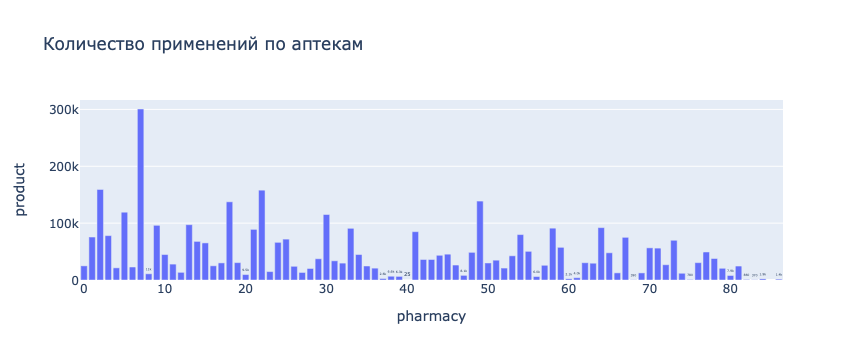

In [20]:
px.bar(
    data.groupby("pharmacy")["product"].count(),
    title="Количество применений по аптекам",
    y="product",
    text_auto=".2s",
)

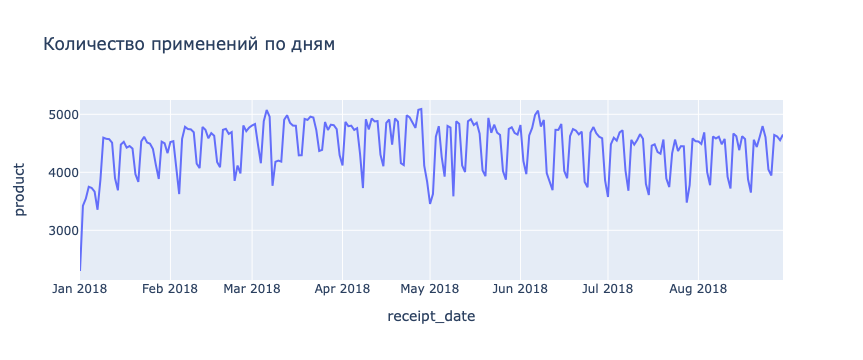

In [21]:
px.line(
    data.groupby("receipt_date")["product"].nunique(),
    title="Количество применений по дням",
    y="product",
)

In [38]:
data_relevant.card_num.nunique()

122868

In [40]:
pd.DataFrame(data.groupby(['card_num', 'receipt_date'])['application'].nunique()).reset_index()

,card_num,receipt_date,application
0,2,2018-01-06,2
1,2,2018-01-08,2
2,2,2018-01-10,6
3,2,2018-01-11,1
4,2,2018-01-12,4
...,...,...,...
1337565,403429824,2018-03-08,3
1337566,403429824,2018-03-15,7
1337567,403429824,2018-05-19,1
1337568,403430988,2018-04-26,3


Сначала переименуем столбцы данных для более удобной работы

В скоупе проекта приведены следующие шаги обработки данных:
* столбец "Код товара" не рассматривается, так как представляет из себя код товара из другой базы данных
* покупатели без карты лояльности (код 199802) не рассматриваются
* покупки бесплатных товаров не рассматриваются
* покупатели с суммарным количеством товаров ниже 4 (менее 4 приобретенных товаров за весь рассматриваемый период)  и суммарным количеством закрытых чеков не более 2 не рассматриваются при прогнозировании

Реализуем все эти ограничения

In [6]:
# удаление столбца Код товара
data.drop(columns=["product_code"], inplace=True)

In [7]:
# удаление покупателей без карты лояльности
data_relevant = data[(data["card_num"] != 199802) & (data["retail_price"] != 0)]

Как было установлено в разведывательном анализе данных, товары с нулевой ценой обладают только нулевой ценой и никакие другие товары нулевой ценой не обладают. Воспользуемся этим для удаления таких позиций из нашего датасета.

In [8]:
card_unique_prod = pd.DataFrame(data_relevant.groupby("card_num")["product"].nunique())

In [9]:
card_unique_prod = card_unique_prod[card_unique_prod["product"] < 4]

In [10]:
def get_receipt(x):
    return f"{str(x[0])} {str(x[1])} {str(x[2])}"


data_relevant["receipt_unique"] = data_relevant[
    ["receipt_date", "receipt_num", "pharmacy"]
].progress_apply(get_receipt, axis=1)

dc_rec = pd.DataFrame(data_relevant.groupby("card_num")[["receipt_unique"]].nunique())

  0%|          | 0/3755277 [00:00<?, ?it/s]

In [11]:
dc_rec = dc_rec[dc_rec["receipt_unique"] <= 2]

In [12]:
def get_total_prods(row):
    return card_unique_prod[card_unique_prod.index == row].values[0][0]


def get_total_checks(row):
    return dc_rec[dc_rec.index == row].values[0][0]

In [13]:
data_relevant = data_relevant.assign(
    total_checks=data_relevant.card_num.isin(dc_rec.index).astype(int)
)
data_relevant = data_relevant.assign(
    total_products=data_relevant.card_num.isin(card_unique_prod.index).astype(int)
)

In [14]:
data_relevant = data_relevant[
    (data_relevant["total_products"] == 0) & (data_relevant["total_checks"] == 0)
]

In [15]:
data_relevant.drop(columns=["total_checks", "total_products"], inplace=True)

In [16]:
data_relevant["month"] = pd.to_datetime(data_relevant["receipt_date"]).dt.month

In [17]:
data_relevant.to_csv("data_preprocessed.csv")

# Модель

## Отбор признаков для кластеризации

В качестве тестовой выборки возьмем весь август

In [ ]:
train_data = data_relevant[pd.to_datetime(data_relevant["receipt_date"]).dt.month != 8]
test_data = data_relevant[pd.to_datetime(data_relevant["receipt_date"]).dt.month == 8]

In [ ]:
train_data["card_num"].nunique(), train_data["application"].nunique()

(121803, 632)

In [ ]:
data_relevant["card_num"].nunique(), data_relevant["application"].nunique()

(122868, 634)

In [ ]:
train_data.head()

,pharmacy,card_num,receipt_date,product,cashier_num,receipt_num,application,retail_price,receipt_unique,month
3,0,2363656,2018-01-05,784213,0,1,379517,530.74,2018-01-05 1 0,1
4,0,2363656,2018-01-05,784213,0,1,379517,530.74,2018-01-05 1 0,1
7,0,2364030,2018-01-04,768150,0,3,379753,79.31,2018-01-04 3 0,1
8,0,2364030,2018-01-04,778137,0,3,379753,217.95,2018-01-04 3 0,1
9,0,2364030,2018-01-15,772668,0,4,379956,745.22,2018-01-15 4 0,1


Итого у нас всего 122 868 уникальных покупателей, из которых 121 803 появились до августа и вошли в тренировочную выборку.

Получается, о 1065 покупателях мы знаем информацию только с августа.

Выделим следующие признаки для каждого из них:

* общее число покупок
* среднее число покупок в месяц
* минимальное число покупок в месяц
* максимальное число покупок в месяц
* средний чек
* максимальный чек
* минимальный чек
* самый частый номер аптеки
* самое популярное применение
* второе самое популярное применение (если такого нет, запишем сюда первое)
* третье самое популярное применение (если такого нет, запишем сюда второе)



Сначала создадим функцию, которая сможет преобразовать изначальный датасет в подходящий для кластеризации:

In [ ]:
def transform_data(data):
    dataset = data.groupby("card_num").agg(
        {
            "receipt_unique": "nunique",
            "product": "nunique",
            "receipt_date": "nunique",
            "application": "nunique",
            "retail_price": ["mean", "std", "min", "max"],
        }
    )

    # число позиций в чеке в месяц (среднее, минимальное, максимальное)
    dataset["mean_purch_month"] = (
        data.groupby(["card_num", "month"]).size().unstack().fillna(0).mean(axis=1)
    )
    dataset["min_purch_month"] = (
        data.groupby(["card_num", "month"]).size().unstack().fillna(0).min(axis=1)
    )
    dataset["max_purch_month"] = (
        data.groupby(["card_num", "month"]).size().unstack().fillna(0).max(axis=1)
    )

    # сумма покупок в месяц (средняя, минимальная, максимальная)
    dataset["mean_price_month"] = (
        data.groupby(["card_num", "month"])["retail_price"]
        .mean()
        .unstack()
        .fillna(0)
        .mean(axis=1)
    )
    dataset["min_price_month"] = (
        data.groupby(["card_num", "month"])["retail_price"]
        .mean()
        .unstack()
        .fillna(0)
        .min(axis=1)
    )
    dataset["max_price_month"] = (
        data.groupby(["card_num", "month"])["retail_price"]
        .mean()
        .unstack()
        .fillna(0)
        .max(axis=1)
    )

    # число дней походов в аптеку в месяц (среднее и максимальное)
    dataset["mean_days_month"] = (
        data.groupby(["card_num", "month"])["receipt_date"]
        .nunique()
        .unstack()
        .fillna(0)
        .mean(axis=1)
    )
    dataset["max_days_month"] = (
        data.groupby(["card_num", "month"])["receipt_date"]
        .nunique()
        .unstack()
        .fillna(0)
        .max(axis=1)
    )

    # среднее число различных применений, купленных за месяц (одно и то же или куча разных)
    dataset["mean_app_month"] = (
        data.groupby(["card_num", "month"])["application"]
        .nunique()
        .unstack()
        .fillna(0)
        .mean(axis=1)
    )

    # в конце заполним пропуски, тк стандартное отклонение может отсутствовать для покупателей,
    # у которых в train попала лишь одна покупка
    return dataset.fillna(0)

Теперь применим ее для всех данных, для train и для test

In [ ]:
gb_all = transform_data(data_relevant)
gb_train = transform_data(train_data)
gb_test = transform_data(test_data)

gb_train.describe()

receipt_unique        product   receipt_date    application  \
             nunique        nunique        nunique        nunique   
count  121803.000000  121803.000000  121803.000000  121803.000000   
mean        8.921045      18.960190       8.637718      14.420105   
std        10.278539      29.074792       7.799900      12.432415   
min         1.000000       1.000000       1.000000       1.000000   
25%         4.000000       8.000000       4.000000       7.000000   
50%         6.000000      14.000000       6.000000      11.000000   
75%        11.000000      23.000000      11.000000      18.000000   
max      1310.000000    2734.000000     207.000000     361.000000   

        retail_price                                              \
                mean            std            min           max   
count  121803.000000  121803.000000  121803.000000  121803.00000   
mean      598.206869     594.620420      70.474931    2215.61558   
std       389.538027     537.920922     166.321470    2078.93224   
min        11.740000       0.000000       0.010000      11.74000   
25%       379.480610     304.161994      10.500000    1039.59000   
50%       513.353587     457.000572      31.060000    1631.27000   
75%       704.163420     705.869603      72.780000    2682.07000   
max     15955.750000   12918.760073   15955.750000   48870.37000   

      mean_purch_month min_purch_month max_purch_month mean_price_month  \
                                                                          
count    121803.000000   121803.000000   121803.000000    121803.000000   
mean          3.479172        0.380590        9.761919       365.349459   
std           8.109767        3.676885       15.418914       298.351721   
min           0.142857        0.000000        1.000000         1.677143   
25%           1.285714        0.000000        5.000000       173.089452   
50%           2.285714        0.000000        8.000000       296.135816   
75%           4.142857        0.000000       12.000000       471.690361   
max        1265.285714      672.000000     2370.000000     10044.897571   

      min_price_month max_price_month mean_days_month max_days_month  \
                                                                       
count   121803.000000   121803.000000   121803.000000  121803.000000   
mean        34.731689     1050.275155        1.233960       3.111820   
std        114.815445      984.808040        1.114271       1.994148   
min          0.000000       11.740000        0.142857       1.000000   
25%          0.000000      547.138333        0.571429       2.000000   
50%          0.000000      797.220000        0.857143       3.000000   
75%          0.000000     1220.404762        1.571429       4.000000   
max       4397.273333    44236.720000       29.571429      31.000000   

      mean_app_month  
                      
count  121803.000000  
mean        2.789109  
std         3.349421  
min         0.142857  
25%         1.142857  
50%         2.000000  
75%         3.428571  
max       219.714286

Найдем покупателей, информация о которых появилась только в августе

In [ ]:
gb_test[~np.in1d(gb_test.index, gb_train.index)]

receipt_unique product receipt_date application retail_price  \
                nunique nunique      nunique     nunique         mean   
card_num                                                                
690                   3      13            3          12   349.493846   
1016                  3      10            3           8   326.007500   
2958                  3      10            3           9   399.316000   
3834                  3       9            3           9   436.610000   
8904                  3       6            3           5   540.421667   
...                 ...     ...          ...         ...          ...   
11255624              3       8            2           7   665.931111   
32340036              4      12            4           7   211.063333   
32673180              4       6            4           5   638.665000   
32674416              4      22            4          19   194.344167   
32675150              3       4            3           4   660.376000   

                                      mean_purch_month min_purch_month  \
                 std     min      max                                    
card_num                                                                 
690       379.217255   17.80  1204.67             13.0              13   
1016      262.798584   25.36   742.09             12.0              12   
2958      332.691401   11.92  1111.30             10.0              10   
3834      532.325032   64.77  1834.22              9.0               9   
8904      552.081085   48.99  1445.31              6.0               6   
...              ...     ...      ...              ...             ...   
11255624  836.344705  174.39  2807.70              9.0               9   
32340036  160.309332   94.31   629.48             12.0              12   
32673180  685.450897   47.96  1935.75              6.0               6   
32674416  159.169936   33.81   708.12             24.0              24   
32675150  472.436155   48.05  1377.34              5.0               5   

         max_purch_month mean_price_month min_price_month max_price_month  \
                                                                            
card_num                                                                    
690                   13       349.493846      349.493846      349.493846   
1016                  12       326.007500      326.007500      326.007500   
2958                  10       399.316000      399.316000      399.316000   
3834                   9       436.610000      436.610000      436.610000   
8904                   6       540.421667      540.421667      540.421667   
...                  ...              ...             ...             ...   
11255624               9       665.931111      665.931111      665.931111   
32340036              12       211.063333      211.063333      211.063333   
32673180               6       638.665000      638.665000      638.665000   
32674416              24       194.344167      194.344167      194.344167   
32675150               5       660.376000      660.376000      660.376000   

         mean_days_month max_days_month mean_app_month  
                                                        
card_num                                                
690                  3.0              3           12.0  
1016                 3.0              3            8.0  
2958                 3.0              3            9.0  
3834                 3.0              3            9.0  
8904                 3.0              3            5.0  
...                  ...            ...            ...  
11255624             2.0              2            7.0  
32340036             4.0              4            7.0  
32673180             4.0              4            5.0  
32674416             4.0              4           19.0  
32675150             3.0              3            4.0  

[1065 rows x 17 columns]

## Кластеризация

Мы можем кластеризовать покупателей по каким-то признакам, а можем кластеризовать покупателей по их поведению в течение времени - по их временным рядам

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
clust_train = scaler.fit_transform(gb_train.to_numpy())
clust_test = scaler.transform(
    gb_test[~np.in1d(gb_test.index, gb_train.index)].to_numpy()
)
clust_train.shape, clust_test.shape

((121803, 17), (1065, 17))

In [ ]:
clust_train.max().max()

182.6606462772714

In [ ]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=10, max_iter=1000).fit(clust_train)

In [ ]:
preds = clustering.predict(clust_test)

In [ ]:
set(clustering.predict(clust_test))

{1, 2, 3, 5, 7, 8}

Так выглядят "идеальные" представители каждого из кластеров - то есть центры кластеров.


In [ ]:
pd.DataFrame(
    scaler.inverse_transform(clustering.cluster_centers_), columns=gb_train.columns
)

receipt_unique      product receipt_date application retail_price  \
         nunique      nunique      nunique     nunique         mean   
0       6.292654    12.396880     6.175636   10.393534  1018.351958   
1     118.032468   429.188312    80.519481  166.246753   547.839797   
2       8.097872    15.137234     7.902128   11.996277  2123.507656   
3      13.298842    28.684389    12.994886   21.921755   497.182179   
4     367.750000  1704.125000   167.500000  299.000000   559.901976   
5       4.787002    10.562989     4.712768    8.893462   458.792168   
6    1129.500000  2725.500000   206.500000  354.000000   477.814239   
7      19.648947    35.027632    19.248816   25.496184   666.712028   
8      35.790498    76.754722    33.809388   49.414711   535.710590   
9       1.695167     1.713755     1.676580    1.572491  2689.181094   

                                          mean_purch_month min_purch_month  \
           std          min           max                                    
0  1120.650125   104.169469   3708.528382         2.181912    1.775787e-02   
1   793.219281     4.920130   8912.911948        84.772727    2.205195e+01   
2  3320.466316   111.492255  11466.031665         2.912158    2.260638e-01   
3   504.897202    23.878661   2223.788652         5.197307    2.083772e-01   
4   790.181312     4.031250  15512.203750       538.500000    2.021250e+02   
5   382.514579    78.038244   1263.284971         1.731118    6.748534e-03   
6   735.758229     5.245000  22591.755000      1198.285714    6.375000e+02   
7   698.190131    27.013163   3202.457996         7.330789    2.495263e+00   
8   643.149419    10.368497   3952.651531        15.614359    4.116199e+00   
9   399.036459  2339.725576   3114.318996         0.311206    5.551115e-16   

  max_purch_month mean_price_month min_price_month max_price_month  \
                                                                     
0        6.994710       598.758372    2.592707e+00     2004.198920   
1      182.974026       524.629638    2.815929e+02      839.926801   
2        8.223404      1439.590066    6.117137e+01     5494.919414   
3       13.935629       383.867873    1.733989e+01      871.745644   
4      881.750000       562.757622    4.543415e+02      643.181963   
5        6.458189       206.249309    8.871642e-01      688.263068   
6     1920.500000       478.992692    4.309448e+02      542.454595   
7       14.197368       715.698321    3.626567e+02     1281.780226   
8       33.578993       505.661207    2.135171e+02      883.837707   
9        1.565056       555.135615   -7.815970e-14     2846.724249   

  mean_days_month max_days_month mean_app_month  
                                                 
0        0.882234       2.419442       1.874330  
1       11.502783      18.870130      47.561224  
2        1.128875       2.776064       2.402736  
3        1.856412       4.469845       4.236378  
4       23.928571      28.125000     155.517857  
5        0.673253       2.188801       1.489767  
6       29.500000      31.000000     218.571429  
7        2.749831       4.826711       5.875677  
8        4.829913       8.990555      11.394636  
9        0.239511       1.204461       0.269782

## Модель 1.1. Рекомендательная система

In [ ]:
# !pip install lightfm

In [ ]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

Создадим датасеты с взаимодействием покупателя с применением, где сила взаимодействия - количество раз, которое покупатель купил это применение

In [ ]:
interactions_train = (
    train_data.groupby(["card_num", "application"])
    .size()
    .unstack()
    .fillna(0)
    .stack()
    .reset_index()
)
interactions_train = interactions_train.rename(columns={0: "event_strength"})
interactions_train = interactions_train[interactions_train["event_strength"] != 0]

In [ ]:
interactions_test = (
    test_data[np.in1d(test_data["card_num"], train_data["card_num"])]
    .groupby(["card_num", "application"])
    .size()
    .unstack()
    .fillna(0)
    .stack()
    .reset_index()
)
interactions_test = interactions_test.rename(columns={0: "event_strength"})
interactions_test = interactions_test[interactions_test["event_strength"] != 0]

In [ ]:
interactions_train.shape, interactions_test.shape

((1756412, 3), (280207, 3))

Создадим список уникальных применений и загрузим все данные в датасет для создания разреженных матриц

In [ ]:
applications = data_relevant["application"].unique()

In [ ]:
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit_partial(users=(x for x in gb_train.index), items=(x for x in applications))

train_interactions, train_weights = dataset.build_interactions(
    [tuple(i) for i in interactions_train.to_numpy()]
)

test_interactions, test_weights = dataset.build_interactions(
    [tuple(i) for i in interactions_test.to_numpy()]
)

In [ ]:
import scipy.sparse as sp

user_features = sp.csr_matrix(clust_train)

Поскольку сила взаимодейтсвия - это целое число от 0 до бексконечности, модель может получиться не очень хорошей, поэтому отмасштабируем данные

In [ ]:
scaler = StandardScaler()
scaled_tr_weights = sp.csr_matrix(scaler.fit_transform(train_weights.toarray()))
scaled_test_weights = sp.csr_matrix(scaler.transform(test_weights.toarray()))

In [ ]:
model = LightFM(loss="warp", random_state=42)
model.fit(train_weights, user_features=user_features, epochs=10)

Измерим precision и recall

In [ ]:
pr = precision_at_k(
    model=model, test_interactions=test_interactions, k=5, user_features=user_features
).mean()
rec = recall_at_k(
    model=model, test_interactions=test_interactions, k=5, user_features=user_features
).mean()
pr, rec

(0.122051276, 0.14883259715654718)

Теперь реализуем функцию, измеряющую качество 

In [ ]:
ranks = model.predict_rank(train_interactions, user_features=user_features)
ranks = ranks.toarray()

In [ ]:
import scipy.sparse as sp

In [ ]:
train_weights.shape

(121803, 634)

In [ ]:
uid_array = np.repeat([2], applications.shape[0])
model.predict(1111, np.arange(0, 634), user_features=user_features, num_threads=4).max()

237.7258

In [ ]:
model.item_embeddings.shape

(634, 10)

In [ ]:
applications[np.argwhere((ranks[0] > 0) & (ranks[0] <= 10))].reshape(1, -1)[0]

array([379932, 379411, 379841, 379937, 379934, 379414, 379930, 379921,
       379936])

In [ ]:
count_nonzero(ranks.toarray())

280207

In [ ]:
model.predict(user_ids=2, item_ids=applications)

ValueError: ignored

In [ ]:
model.predict_rank(test_interactions, train_interactions)

ValueError: ignored

In [ ]:
train_weights.row.shape

(1756412,)